In [34]:
import pyshtools as sh  #py spherical harmonics tools package https://shtools.github.io/SHTOOLS/index.html
from scipy.special import factorial
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors, cm

# Generating isotropic gaussian random fields on the sphere using spherical harmonics


__Plan :__

1. A lat/lon grid is defined

2. We use the lemma in https://arxiv.org/pdf/1305.1170.pdf (section 5) to generate isotropic GRF on $\mathbb{S}^2$.

3. Plots

4. Verifications using an ensemble of GRFs to 
    
    
__Computing the anisotropic tensor on the sphere__ 

The anisotropic tensor (correlation sense) is related to the metric tensor (correlation sense) according to $\mathbf{s} = \mathbf{g}^{-1}$ (the matrix inverse). The metric tensor $\mathbf{g}$  (correlation sense) is defined by :
$$
g = \mathbb{E} \left[ \left( \nabla \tilde{\zeta} \right) \left( \nabla \tilde{\zeta} \right)^T \right],
$$

with $\nabla = \left(\frac{\partial}{\partial \theta}, \frac{1}{\cos \theta}\frac{\partial}{\partial \varphi} \right)$ for the sphere $\mathbb{S}^2$, and $\tilde{\zeta} = \zeta / \sigma $ the normalized error.

__Limitations__ :
Requires the computation of $\mathbf{B}^{1/2}$ which becomes very costly when the grid definition augments.

## 1. Defining the lat/lon grid

In [105]:
n = 360
m,n = 2*n, n # number longitudes, number of latitudes 
phi,theta = np.linspace(-np.pi, np.pi, m+1)[:-1], np.linspace(-np.pi/2,np.pi/2,n+2)[1:-1]

dtheta = np.abs(theta[1]-theta[0])
dphi = np.abs(phi[1]-phi[0])

THETA, PHI = np.meshgrid(range(n),range(m))
deg_to_radian = 2*np.pi/360

xtheta, xphi = np.meshgrid(theta, phi)

R = 1

ex,ey,ez = np.eye(3)


X = R * np.cos(xtheta)*np.cos(xphi)
Y = R * np.cos(xtheta)*np.sin(xphi)
Z = R * np.sin(xtheta)

OM = X[:,:,np.newaxis]*ex + Y[:,:,np.newaxis]*ey + Z[:,:,np.newaxis]*ez

def projection(vecteur):
    return (np.dot(vecteur,ex),np.dot(vecteur,ey),np.dot(vecteur,ez))

## 2. GRF using spherical harmonics

In [106]:
import pyshtools as sh  #py spherical harmonics tools package https://shtools.github.io/SHTOOLS/index.html
from scipy.special import factorial

def random_isotropic_ensemble(ensemble_size,m,n,Lmax=20, alpha=0.7):
    phi,theta = np.linspace(-np.pi, np.pi, m+1)[:-1], np.linspace(-np.pi/2,np.pi/2,n+2)[1:-1]
    
    #phi,theta = np.linspace(-np.pi,np.pi,m), np.linspace(-np.pi/2,np.pi/2,n)
    ls = [ [index] * (index+1) for index in range(0,Lmax+1)]
    ms=  [  list(range(0,l+1)) for l in range(0,Lmax+1)  ]

    ls = np.array(np.sum(ls))
    ms = np.array(np.sum(ms))

    Llm =    (  (factorial(ls-ms)/factorial(ls+ms) * (2*ls+1)/(4*np.pi))**.5  ) * \
        np.array([sh.legendre.legendre_lm(ls,ms, np.sin(_theta),normalization='unnorm') for _theta in theta]) 

    # influence the length-scales by putting more or less weigth on the spherical harmonics of higher order.
    Al = alpha**np.arange(0,Lmax+1,1)

    Ll0_index = [i*(i+1)//2 for i in range(Lmax+1)]

    ensemble = np.zeros((ensemble_size,m,n))
    for l, Al_coef in enumerate(Al):
        ensemble += Al_coef**.5 * Llm.T[Ll0_index[l]] * np.random.normal(0,1,ensemble_size)[:,np.newaxis,np.newaxis]

        for k in range(1,l+1):
            mm  = Ll0_index[l] + k
            ensemble += (2*Al_coef)**.5 * Llm.T[mm] * (np.random.normal(0,1,ensemble_size)[:,np.newaxis,np.newaxis] * np.cos(k*phi)[:,np.newaxis] + 
                                              np.random.normal(0,1,ensemble_size)[:,np.newaxis,np.newaxis] * np.sin(k*phi)[:,np.newaxis])
    
    return ensemble

## 3. Plots 

#### planisphere

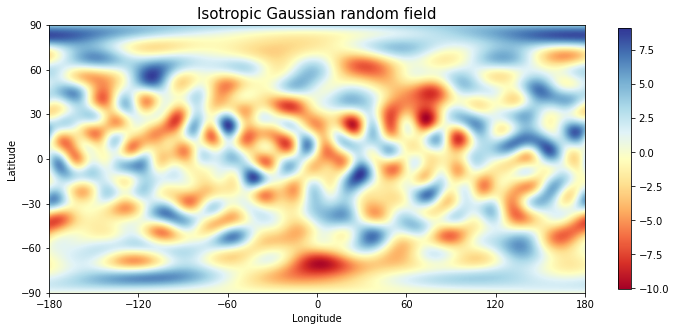

In [129]:
alpha=0.9

grf = random_isotropic_ensemble(1,m,n,alpha=alpha)[0]

plt.figure(figsize=(12,6))
plt.title("Isotropic Gaussian random field",fontsize=15)
plt.imshow(grf.T,extent=[-180,180,-90,90],cmap='RdYlBu');
plt.colorbar(shrink=0.8);
plt.xlabel("Longitude"); plt.ylabel('Latitude');
plt.xticks(np.arange(-180,181,60));
plt.yticks(np.arange(-90,91,30));

#### spherical

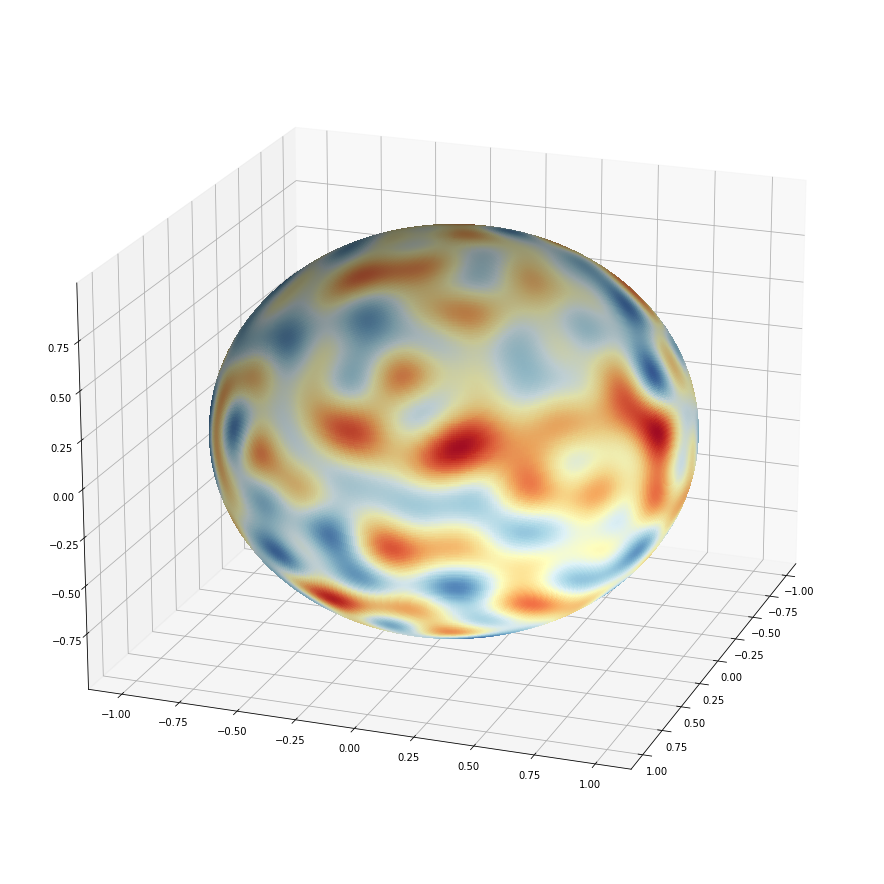

In [108]:
from matplotlib import colors, cm
fig = plt.figure(figsize=(16,16))
ax = fig.add_subplot(1,1,1,projection='3d')

ax.view_init(elev=20., azim=20)

strength = grf
norm=colors.Normalize(vmin = np.min(strength),
                      vmax = np.max(strength), clip = False)

surface = ax.plot_surface(*projection(OM), rstride=1, cstride=1,
                       linewidth=0, antialiased=False,
                       facecolors=cm.RdYlBu(norm(strength)),zorder=1)

## 4. Sanity check

With verify that the random fields are well isotropic using an ensemble.

In [109]:
def sphere_diagnosis(ensemble):
    mean = ensemble.mean(axis=0)
    std = ensemble.std(axis=0)
    
    errors = (ensemble - mean)/std
    
    d_phi_errors =  ((np.roll(errors,-1,axis=1) - np.roll(errors,1,axis=1))/2/dphi ) / np.cos(xtheta)
    d_theta_errors =  ((np.roll(errors,-1,axis=2) - np.roll(errors,1,axis=2))/2/dtheta )
    del errors
    d_theta_errors[:,:,[0,n-1]] = 0
    d_phi_errors[:,:,[0,n-1]] = 0
    
    metric_tensor = np.zeros((2,2,mean.shape[0],mean.shape[1]))
    
    metric_tensor[0,0] = (d_theta_errors**2).mean(axis=0)
    metric_tensor[1,1] = (d_phi_errors**2).mean(axis=0)
    metric_tensor[0,1] = (d_phi_errors*d_theta_errors).mean(axis=0)
    metric_tensor[1,0] = (d_phi_errors*d_theta_errors).mean(axis=0)
    
    aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],
         [-metric_tensor[0,1], metric_tensor[0,0]]])
    aspect_tensor[:,:,:,[0,-1]] = 0
    
    return mean, std, aspect_tensor[:,:,:,1:-1]

N = 1600
grfs = random_isotropic_ensemble(N,m,n,Lmax=20, alpha=alpha)
mean, std, aspect_tensor = sphere_diagnosis(grfs)


<ipython-input-109-0d5caadcaef6>:20: RuntimeWarning: divide by zero encountered in true_divide
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],
<ipython-input-109-0d5caadcaef6>:20: RuntimeWarning: invalid value encountered in multiply
  aspect_tensor =1/(metric_tensor[0,0] * metric_tensor[1,1] - metric_tensor[0,1]**2) * np.array([[metric_tensor[1,1],-metric_tensor[0,1]],


__Empirical estimation of the length-scale correlation__

As we can not prescribed a length-scale $l_h$ when generating the GRF, we diagnose it empirically after the ensemble generation as follows. 


$$
\hat{l}_h = \frac{1}{m \cdot n} \sum_{i=1}^n\sum_{j=1}^m \sqrt{ \hat{\mathbf{s}}_{\theta \theta}(\theta_i,\varphi_j)}.
$$

It corresponds to the spatial average of the $\theta \theta$ entry the empirically computed anisotropic tensor.

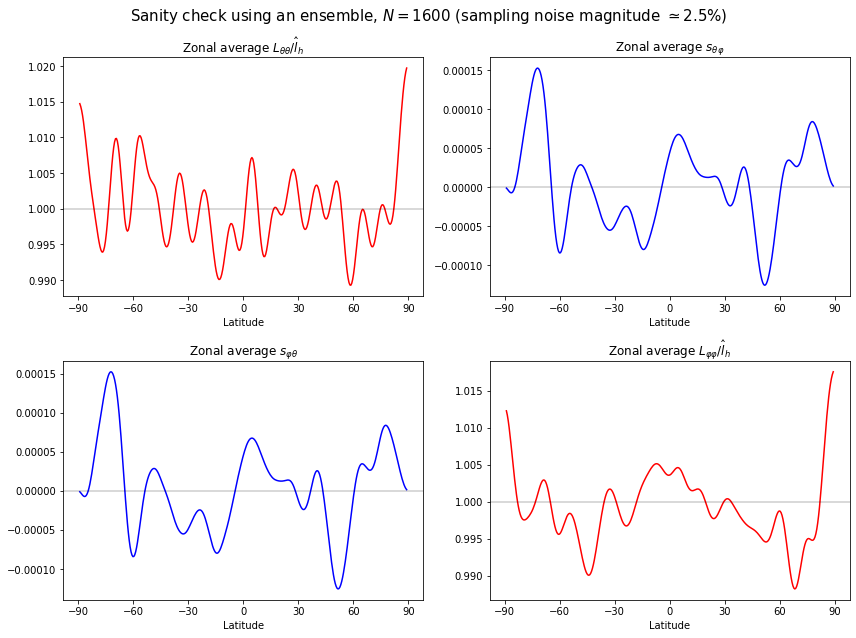

In [112]:
lh_hat = (aspect_tensor[0,0]**.5).mean()

chars = [r'$L_{\theta\theta}/\hat{l}_h$',r'$s_{\theta\varphi}$',r'$s_{\varphi\theta}$',r'$L_{\varphi\varphi}/\hat{l}_h$']

fig, ax = plt.subplots(2,2,figsize=(12,9))

fig.suptitle(fr"Sanity check using an ensemble, $N=${N} (sampling noise magnitude $\simeq${100/N**.5:.1f}%)"
             ,fontsize=15)
for i in range(2):
    for j in range(2):
        div_by = lh_hat*(i==j) + 1*(i!=j)
        power = 0.5*(i==j) + 1*(i!=j)
        title = chars[i*2+j]
        ax[i,j].set_title("Zonal average "+title)
        c = 'r' if i==j else 'b'
        ax[i,j].plot(theta[1:-1]/(np.pi/2)*90,aspect_tensor[i,j].T.mean(axis=1)**power/div_by,c=c)
        ax[i,j].set_xticks([-90,-60,-30,0,30,60,90])
        ax[i,j].set_xlabel("Latitude")
        ax[i,j].axhline(1*(i==j),c='k',alpha=0.2)
fig.tight_layout();

> - We observe that $L_{\theta\theta}$ and $L_{\varphi\varphi}$ are equal, and $s_{\theta\varphi}=0$.
- The random fields are effectively isotropic !